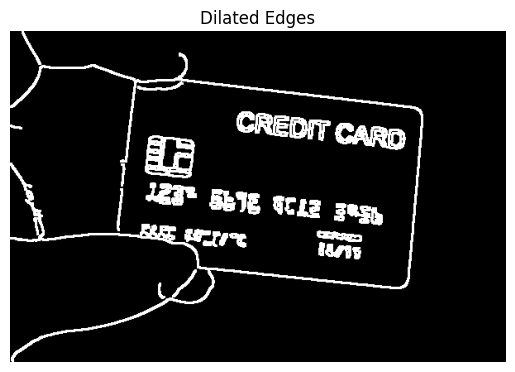

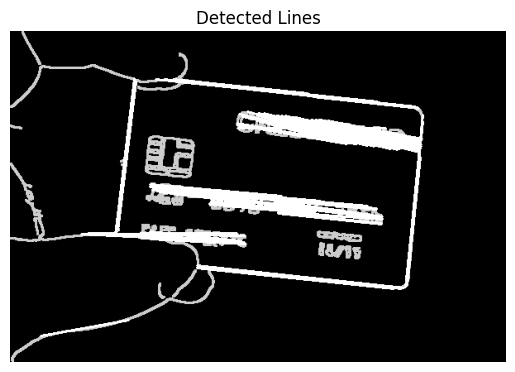

C:\Users\Mohamed Amr\AppData\Local\Temp\ipykernel_15148\152555640.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  x_top = (0 - intercept) / slope
C:\Users\Mohamed Amr\AppData\Local\Temp\ipykernel_15148\152555640.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  x_bottom = (height - intercept) / slope


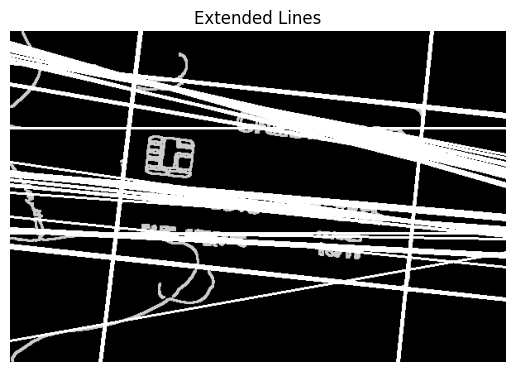

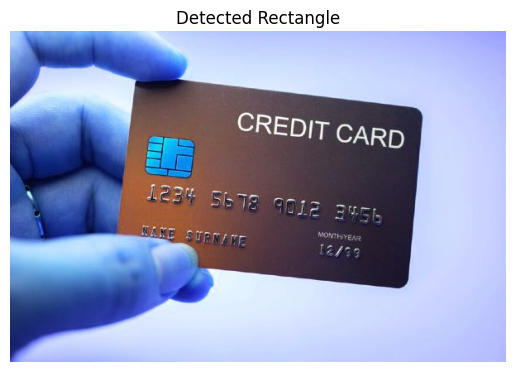

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('11 - Ya setty ew3i.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def showImage(name, image, cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')  # Hide axis
    plt.title(name)
    plt.show()

# Preprocess the image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply Canny edge detector
edges = cv2.Canny(blurred, 10, 110)

# Define a rectangular kernel for dilation
kernel_size = (3, 3)  # Adjust the size as needed
rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

# Apply dilation with the rectangular kernel
dilated_edges = cv2.dilate(edges, rectangular_kernel, iterations=1)

# Display the dilated edges
showImage("Dilated Edges", dilated_edges, cmap='gray')

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid (changed from 1270 to 180)
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(dilated_edges) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(dilated_edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Draw the lines on the image
lines_edges = cv2.addWeighted(dilated_edges, 0.8, line_image, 1, 0)
showImage("Detected Lines", lines_edges, cmap='gray')

def extend_line(x1, y1, x2, y2, img_shape):
    """Extend a line segment to the borders of the image."""
    height, width = img_shape[:2]
    dx = x2 - x1
    dy = y2 - y1

    if dx == 0:
        return [(x1, 0), (x1, height)]
    
    slope = dy / dx
    intercept = y1 - slope * x1

    def get_line_endpoints():
        endpoints = []
        x_top = (0 - intercept) / slope
        if 0 <= x_top < width:
            endpoints.append((int(x_top), 0))

        x_bottom = (height - intercept) / slope
        if 0 <= x_bottom < width:
            endpoints.append((int(x_bottom), height))

        y_left = intercept
        if 0 <= y_left < height:
            endpoints.append((0, int(y_left)))

        y_right = slope * width + intercept
        if 0 <= y_right < height:
            endpoints.append((width, int(y_right)))

        return endpoints

    endpoints = get_line_endpoints()
    if len(endpoints) == 2:
        return endpoints
    else:
        return []

# Extend each detected line segment to the image borders
extended_line_image = np.copy(dilated_edges) * 0
for line in lines:
    for x1, y1, x2, y2 in line:
        extended_points = extend_line(x1, y1, x2, y2, dilated_edges.shape)
        if len(extended_points) == 2:
            (x1_new, y1_new), (x2_new, y2_new) = extended_points
            cv2.line(extended_line_image, (x1_new, y1_new), (x2_new, y2_new), (255, 0, 0), 2)

# Overlay the extended lines on the original image
lines_edges = cv2.addWeighted(dilated_edges, 0.8, extended_line_image, 1, 0)
showImage("Extended Lines", lines_edges, cmap='gray')

def find_rectangles_from_contours(image):
    """Find rectangles from contours in the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            rect = cv2.boundingRect(approx)
            rectangles.append(rect)
    return rectangles

def draw_best_rectangle(image, rectangles):
    """Draw the most perfect rectangle on the image."""
    best_rect = None
    max_area = 0

    for (x, y, w, h) in rectangles:
        area = w * h
        if area > max_area:
            max_area = area
            best_rect = (x, y, w, h)

    if best_rect:
        x, y, w, h = best_rect
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image

# Find rectangles from contours
rectangles = find_rectangles_from_contours(extended_line_image)
result_image = draw_best_rectangle(image, rectangles)

showImage("Detected Rectangle", result_image)
